This python notebook starts to take a look at the genetic similarities between siblings in the iHART and SSC datasets. On average, siblings are 50% genetic, but any given pair of siblings may be slightly more or slighly less genetically related depending upon which copies of their parents' chromosomes they inherited.

Our data is generated from an algorithm using to phase families jointly.
* Code: https://github.com/kpaskov/PhasingFamilies
* Paper (in progress): https://www.overleaf.com/6361338638csmxvgdprkkv

The algorithm was run on all families in iHART of size <= 6 and all families in SSC. Data is available on sherlock
* iHART: /scratch/PI/dpwall/DATA/iHART/kpaskov/PhasingFamilies/phased_ihart_miss
* SSC: /scratch/PI/dpwall/DATA/iHART/kpaskov/PhasingFamilies/phased_ssc_miss

These directories contain the results from the above algorithm. The algorithm is run on each chromosome separately, so the results for each chromosome are in different files. The algorithm also runs on batches of families of the same size. The file chr.1.familysize.5.phased.txt corresponds to all of the data for families of size 5 on chromosome 1.

There are two types of files:
* .families.txt: These files list the individuals in each family. This list is ordered and indicates the order of the children in the phasing output. As a note, the order of the children is randomized per chromosome, so children in the same family may appear in different orders on different chromosomes.
* .phased.txt These files contain the majority of the phasing information. (columns described below, ignore header in file, needs to be fixed)

Columns in .phased.txt files
* family_id: -
* m_1: presence/absence of a deletion on maternal chromosome 1 (0=deletion, 1=no deletion)
* m_2: presence/absence of a deletion on maternal chromosome 2 (0=deletion, 1=no deletion)
* p_1: presence/absence of a deletion on paternal chromosome 1 (0=deletion, 1=no deletion)
* p_2: presence/absence of a deletion on paternal chromosome 2 (0=deletion, 1=no deletion)
* child1_maternal_state: indicates which maternal chromosome was inherited by child1 (0=m1, 1=m2)
* child1_paternal_state: indicates which paternal chromosome was inherited by child1 (0=m1, 1=m2)
* child2_maternal_state: indicates which maternal chromosome was inherited by child2 (0=m1, 1=m2)
* child2_paternal_state: indicates which paternal chromosome was inherited by child2 (0=m1, 1=m2)
* ... (continues for all children in family)
* mask: indicates whether the model fits well in this region (1=bad fit, 0=good fit)
* start_pos: -
* end_pos: -
* start_index: (useless)
* end_index: (useless)
* length of interval: -
* length of interval (in terms of index): (useless)

In [1]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [3]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [60]:
chroms = [str(x) for x in range(1, 23)] #+ ['X']

ihart_family_sizes = [4, 5, 6]
ihart_phase_dir = '../phased_ihart_miss'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc_miss'


In [61]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x.split('.')[0] and x not in families_with_lcl and x not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 662
Counter({22: 662, 20: 70, 18: 35, 17: 29, 16: 29, 21: 19, 19: 5, 1: 2})
Families with LCL 12
Final families 650
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 516
Counter({22: 516})
Families with LCL 0
Final families 516


In [62]:
from collections import defaultdict, namedtuple

# read in phase information
Interval = namedtuple('Interval', ['chrom', 'start_pos', 'end_pos', 'length', 'has_m1', 'has_m2', 'has_p1', 'has_p2', 'm_unknown', 'p_unknown'])

def load_intervals(phase_dir, family_sizes, families_to_include):
    family_to_intervals = defaultdict(list)
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                    family_to_individuals = dict()
                    next(f) # skip header
                    num_fams_of_size = 0
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            family_to_individuals[family_key] = pieces[1:(1+j)]
                            num_fams_of_size += 1

                # load deletions
                with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header

                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                            length = end_pos - start_pos + 1

                            has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                            children = family_to_individuals[family_key][2:]
                            if inheritance_state[-1] != 1:
                                for i, child in enumerate(children):
                                    if inheritance_state[4+2*i] == 0:
                                        has_m1.append(child)
                                    elif inheritance_state[4+2*i] == 1:
                                        has_m2.append(child)
                                    if inheritance_state[5+2*i] == 0:
                                        has_p1.append(child)
                                    elif inheritance_state[5+2*i] == 1:
                                        has_p2.append(child)

                            m_unknown = list(set(children) - set(has_m1 + has_m2))
                            p_unknown = list(set(children) - set(has_p1 + has_p2))

                            family_to_intervals[family_key].append(Interval(chrom, start_pos, end_pos, length,
                                                                             has_m1, has_m2, has_p1, has_p2,
                                                                             m_unknown, p_unknown))



            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'fammily size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)
                
    return family_to_intervals

ihart_intervals = load_intervals(ihart_phase_dir, ihart_family_sizes, ok_ihart_families)
ssc_intervals = load_intervals(ssc_phase_dir, ssc_family_sizes, ok_ssc_families)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [63]:
from itertools import product, chain

# calculate maternal and paternal similarity between sibpairs

SibPair = namedtuple('SibPair', ['child1', 'child2', 'shared'])

def calculate_sibpair_similarity(family_to_intervals, family_to_individuals):
    sibpairs = dict()

    for family_key, intervals in family_to_intervals.items():
        children = family_to_individuals[family_key][2:]
        for child1 in children:
            for child2 in children:
                if child1 < child2:
                    sibpairs[(child1, child2)] = SibPair(child1, child2, {'mat_same': 0, 'mat_diff': 0, 
                                                                          'pat_same': 0, 'pat_diff': 0,
                                                                         'both_same': 0, 'both_diff': 0})

        for i in intervals:
            mat_shared = list(chain(product(i.has_m1, repeat=2), product(i.has_m2, repeat=2)))
            for child1, child2 in mat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_same'] += i.length

            mat_different = list(chain(product(i.has_m1, i.has_m2), product(i.has_m2, i.has_m1)))
            for child1, child2 in mat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_diff'] += i.length

            pat_shared = list(chain(product(i.has_p1, repeat=2), product(i.has_p2, repeat=2)))
            for child1, child2 in pat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_same'] += i.length

            pat_different = list(chain(product(i.has_p1, i.has_p2), product(i.has_p2, i.has_p1)))
            for child1, child2 in pat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_diff'] += i.length

            for child1, child2 in set(mat_shared) & set(pat_shared):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_same'] += i.length

            for child1, child2 in set(mat_different) | set(pat_different):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_diff'] += i.length
    return sibpairs

ihart_sps = calculate_sibpair_similarity(ihart_intervals, ok_ihart_families)
ssc_sps = calculate_sibpair_similarity(ssc_intervals, ok_ssc_families)

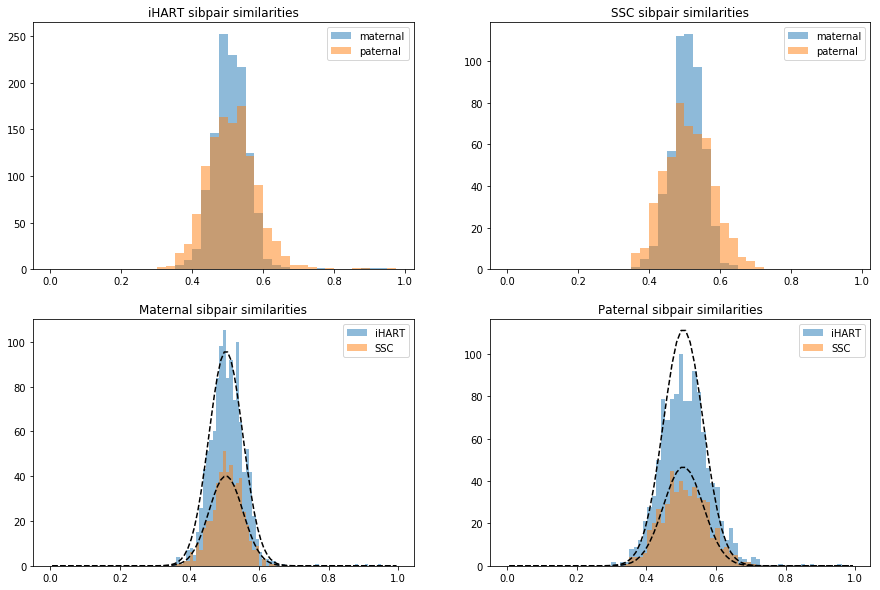

In [64]:
import scipy.stats as stats

ihart_sps_keys = sorted(ihart_sps.keys())
ssc_sps_keys = sorted(ssc_sps.keys())

ihart_mat = [x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]
ihart_pat = [x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]
ihart_both = [x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ihart_sps[y] for y in ihart_sps_keys]]

ssc_mat = [x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]
ssc_pat = [x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]
ssc_both = [x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ssc_sps[y] for y in ssc_sps_keys]]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(ihart_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ihart_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('iHART sibpair similarities')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(ssc_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ssc_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('SSC sibpair similarities')
plt.legend()

plt.subplot(2, 2, 3)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(2, 2, 4)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


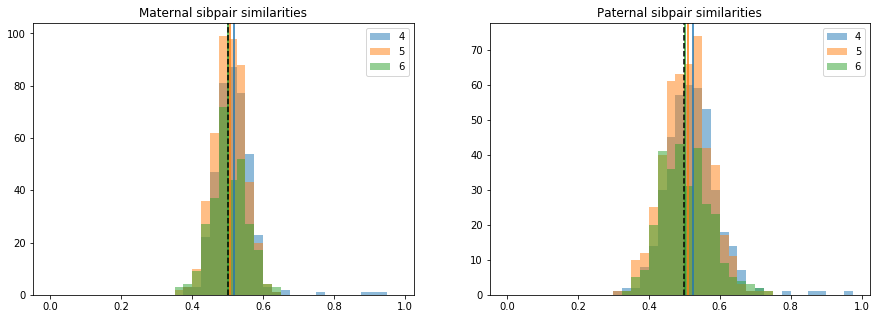

In [65]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# for iHART, break it down by family size
child_to_family_size = dict()
for inds in ok_ihart_families.values():
    for child in inds[2:]:
        child_to_family_size[child] = len(inds)
        
plt.figure(figsize=(15, 5))

for i, j in enumerate(ihart_family_sizes):
    
    m = [x for s, x in zip(ihart_sps_keys, ihart_mat) if child_to_family_size[s[0]]==j]
    p = [x for s, x in zip(ihart_sps_keys, ihart_pat) if child_to_family_size[s[0]]==j]
    b = [x for s, x in zip(ihart_sps_keys, ihart_both) if child_to_family_size[s[0]]==j]
    
    plt.subplot(1, 2, 1)
    plt.hist(m, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(m), color=colors[i])
    
    plt.subplot(1, 2, 2)
    plt.hist(p, bins=np.arange(0, 1, .025), alpha=0.5, label=str(j))
    plt.axvline(np.median(p), color=colors[i])

plt.subplot(1, 2, 1)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
plt.legend()
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Paternal sibpair similarities')

plt.show()

iHART aff-aff 761
iHART aff-unaff 449
iHART unaff-unaff 24
SSC aff-unaff 516


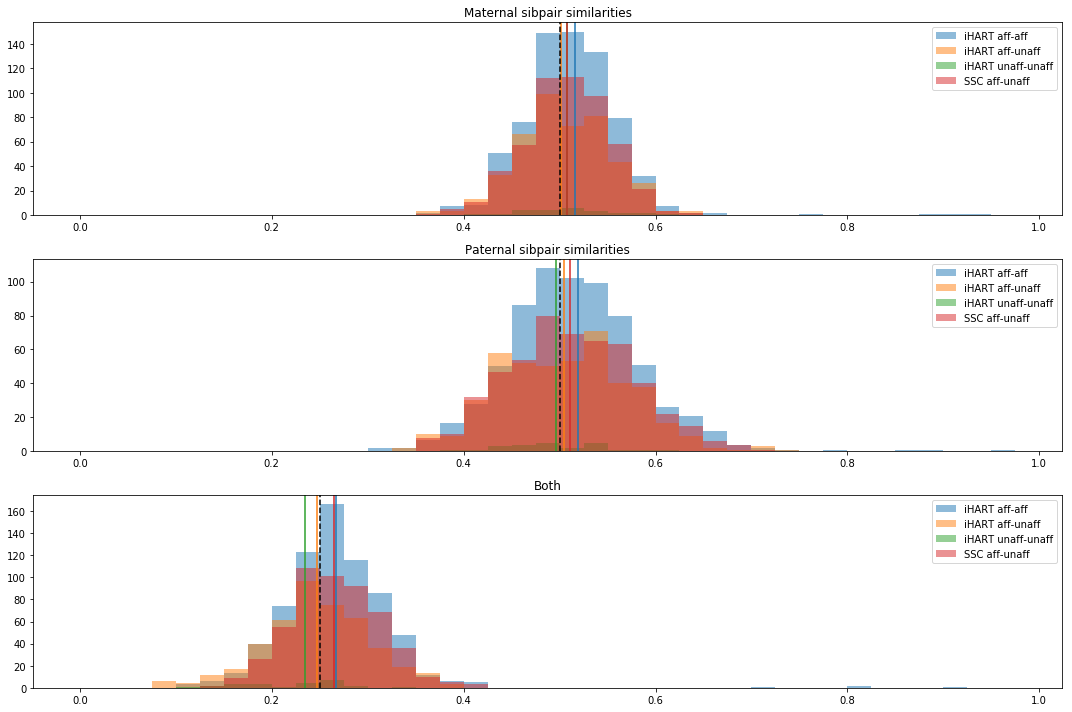

In [66]:
plt.figure(figsize=(15, 10))

ihart_mat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2']
ihart_mat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]
ihart_mat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_mat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1']

ihart_pat_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2']
ihart_pat_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]
ihart_pat_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_pat) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1']

ihart_both_aff_aff = [m for x, m in zip(ihart_sps_keys, ihart_both) if child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '2']
ihart_both_aff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_both) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]
ihart_both_unaff_unaff = [m for x, m in zip(ihart_sps_keys, ihart_both) if child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '1']

ssc_mat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_mat) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]
ssc_pat_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_pat) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]
ssc_both_aff_unaff = [m for x, m in zip(ssc_sps_keys, ssc_both) if (child_id_to_affected[x[0]] == '1' and child_id_to_affected[x[1]] == '2') or (child_id_to_affected[x[0]] == '2' and child_id_to_affected[x[1]] == '1')]

print('iHART aff-aff', len(ihart_mat_aff_aff))
print('iHART aff-unaff', len(ihart_mat_aff_unaff))
print('iHART unaff-unaff', len(ihart_mat_unaff_unaff))
print('SSC aff-unaff', len(ssc_mat_aff_unaff))

plt.subplot(3, 1, 1)
plt.title('Maternal sibpair similarities')
plt.hist(ihart_mat_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_mat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_mat_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_mat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_mat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_mat_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_mat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_mat_aff_unaff), color=colors[3])
plt.axvline(0.5, color='black', linestyle='--')

#m = 0.5
#s = max(np.std(ihart_mat_aff_aff), np.std(ihart_mat_aff_unaff), np.std(ssc_mat_aff_unaff))
#n = min(len(ihart_mat_aff_aff), len(ihart_mat_aff_unaff), len(ssc_mat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 2)
plt.title('Paternal sibpair similarities')
plt.hist(ihart_pat_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_pat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_pat_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_pat_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')

plt.axvline(np.median(ihart_pat_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_pat_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_pat_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_pat_aff_unaff), color=colors[3])
plt.axvline(0.5, color='black', linestyle='--')

#m = 0.5
#s = max(np.std(ihart_pat_aff_aff), np.std(ihart_pat_aff_unaff), np.std(ssc_pat_aff_unaff))
#n = min(len(ihart_pat_aff_aff), len(ihart_pat_aff_unaff), len(ssc_pat_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.subplot(3, 1, 3)
plt.title('Both')
plt.hist(ihart_both_aff_aff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-aff')
plt.hist(ihart_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART aff-unaff')
plt.hist(ihart_both_unaff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='iHART unaff-unaff')
plt.hist(ssc_both_aff_unaff, bins=np.arange(0, 1, .025), alpha=0.5, label='SSC aff-unaff')
plt.axvline(np.median(ihart_both_aff_aff), color=colors[0])
plt.axvline(np.median(ihart_both_aff_unaff), color=colors[1])
plt.axvline(np.median(ihart_both_unaff_unaff), color=colors[2])
plt.axvline(np.median(ssc_both_aff_unaff), color=colors[3])
plt.axvline(0.25, color='black', linestyle='--')

#m = 0.25
#s = max(np.std(ihart_both_aff_aff), np.std(ihart_both_aff_unaff), np.std(ssc_both_aff_unaff))
#n = min(len(ihart_both_aff_aff), len(ihart_both_aff_unaff), len(ssc_both_aff_unaff))
#plt.axvspan(m-(1.96*s/np.sqrt(n)), m+(1.96*s/np.sqrt(n)), color='black', alpha=0.25)

plt.legend()

plt.tight_layout()

plt.show()



In [67]:
print(stats.ttest_ind(ihart_mat_aff_aff, ihart_mat_aff_unaff, equal_var=False))
print(stats.ttest_ind(ihart_pat_aff_aff, ihart_pat_aff_unaff, equal_var=False))
print(stats.ttest_ind(ihart_both_aff_aff, ihart_both_aff_unaff, equal_var=False))

print()
print(stats.ttest_ind([x for x in ihart_mat_aff_aff if x < 0.7], [x for x in ihart_mat_aff_unaff if x < 0.7], equal_var=False))
print(ttest_ind([x for x in ihart_pat_aff_aff if x < 0.7], [x for x in ihart_pat_aff_unaff if x < 0.7], equal_var=False))
print(stats.ttest_ind([x for x in ihart_both_aff_aff if x < 0.5], [x for x in ihart_both_aff_unaff if x < 0.5], equal_var=False))



Ttest_indResult(statistic=7.07904410862955, pvalue=2.5349350493516133e-12)
Ttest_indResult(statistic=6.89792545415688, pvalue=8.516425694696678e-12)
Ttest_indResult(statistic=8.603594688031086, pvalue=2.6457167180392703e-17)

Ttest_indResult(statistic=1.7357520216205398, pvalue=0.08294977545618723)
Ttest_indResult(statistic=2.402369322952889, pvalue=0.016485245319476458)
Ttest_indResult(statistic=5.444420510135463, pvalue=6.792402449908961e-08)
